In [2]:
#调用torch库
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
#调用numpy库
import numpy as np
#调用matplotlib库
import matplotlib.pyplot as plt
#调用random库
import random

按要求生成二分类模型训练数据与验证数据

In [3]:
n_data = torch.zeros(10000, 200)
X1 = torch.normal(mean=n_data + 1, std=n_data + 0.01)
Y1 = torch.zeros(10000, 1)

X2 = torch.normal(mean=n_data - 1, std=n_data + 0.01)
Y2 = torch.ones(10000, 1)

x_train = torch.cat([X1[:7000], X2[:7000]], dim=0)
x_test = torch.cat([X1[7000:], X2[7000:]], dim=0)
y_train = torch.cat([Y1[:7000], Y2[:7000]], dim=0)
y_test = torch.cat([Y1[7000:], Y2[7000:]], dim=0)

In [4]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([14000, 200]) torch.Size([6000, 200])
torch.Size([14000, 1]) torch.Size([6000, 1])


In [5]:
#使用课上给出的数据读取函数
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features.index_select(0, j), labels.index_select(0, j)

手动实现的前馈神经网络（解决二分类问题）

In [6]:
# 使用课上给出的优化函数进行参数的学习优化
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [7]:
class Feedforward_twoclass:
    def __init__(self, feature_dim, opt, device, hidden=100):
        self.w_in = torch.tensor(np.random.normal(0, 0.01, (feature_dim, hidden)), dtype=torch.float32).to(device)
        self.b_in = torch.zeros(hidden, dtype=torch.float32).to(device)
        self.w_in.requires_grad_(requires_grad=True)
        self.b_in.requires_grad_(requires_grad=True) 

        self.w_out = torch.tensor(np.random.normal(0, 0.01, (hidden, 1)), dtype=torch.float32).to(device)
        self.b_out = torch.zeros(1, dtype=torch.float32).to(device)
        self.w_out.requires_grad_(requires_grad=True)
        self.b_out.requires_grad_(requires_grad=True) 

        self.opt = opt

    def sigmoid(self, x):
        return 1.0 / (1.0 + torch.exp(-x))

    def forward(self, x):
        x = torch.matmul(x, self.w_in) + self.b_in
        x = torch.matmul(x, self.w_out) + self.b_out
        return self.sigmoid(x)

    def learn(self, lr, bs):
        self.opt([self.w_in, self.b_in, self.w_out, self.b_out], lr, bs)

    def reset_grad(self):
        self.w_in.grad.data.zero_()
        self.b_in.grad.data.zero_()
        self.w_out.grad.data.zero_()
        self.b_out.grad.data.zero_()

In [22]:
epoch_num = 300
lr = 0.03
feature_dim = 200
device = 'cuda:1'
opt = sgd
loss = torch.nn.BCELoss()
batch_size = 128
model = Feedforward_twoclass(feature_dim, sgd, device)
train_loss_list = []
test_loss_list = []

In [23]:
for epoch in range(epoch_num):
    for x, y in data_iter(batch_size, x_train, y_train):
        x, y = x.to(device), y.to(device)
        y_hat = model.forward(x).squeeze(1)
        y = y.squeeze(1)
        l = loss(y_hat, y).sum()
        l.backward()
        model.learn(lr, batch_size)
        model.reset_grad()
        train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        counter = 0
        for x, y in data_iter(batch_size, x_test, y_test):
            test_x, test_y = x.to(device), y.to(device)
            test_pred = model.forward(test_x)

            l = loss(test_pred, test_y).sum()
            total_loss += l
            counter += 1
        test_loss_list.append(total_loss.item())
        print('epoch: %d, total loss: %f'%(epoch + 1, total_loss / (counter+1)))

epoch: 1, total loss: 0.659505
epoch: 2, total loss: 0.634212
epoch: 3, total loss: 0.604544
epoch: 4, total loss: 0.568766
epoch: 5, total loss: 0.525935
epoch: 6, total loss: 0.476325
epoch: 7, total loss: 0.421722
epoch: 8, total loss: 0.365241
epoch: 9, total loss: 0.310525
epoch: 10, total loss: 0.260665
epoch: 11, total loss: 0.217480
epoch: 12, total loss: 0.181437
epoch: 13, total loss: 0.152054
epoch: 14, total loss: 0.128387
epoch: 15, total loss: 0.109390
epoch: 16, total loss: 0.094107
epoch: 17, total loss: 0.081739
epoch: 18, total loss: 0.071652
epoch: 19, total loss: 0.063350
epoch: 20, total loss: 0.056455
epoch: 21, total loss: 0.050676
epoch: 22, total loss: 0.045789
epoch: 23, total loss: 0.041623
epoch: 24, total loss: 0.038042
epoch: 25, total loss: 0.034942
epoch: 26, total loss: 0.032239
epoch: 27, total loss: 0.029869
epoch: 28, total loss: 0.027777
epoch: 29, total loss: 0.025921
epoch: 30, total loss: 0.024266
epoch: 31, total loss: 0.022783
epoch: 32, total 

绘制训练loss曲线

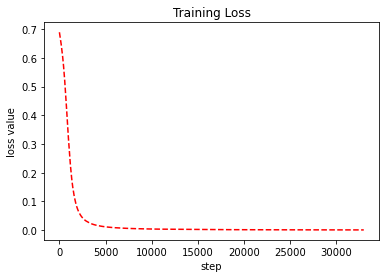

In [24]:
x = [i + 1 for i in range(len(train_loss_list))]
y = train_loss_list
l1 = plt.plot(x, y, 'r--', label='train_loss')

plt.title('Training Loss')
plt.xlabel('step')
plt.ylabel('loss value')
plt.show()

绘制验证loss曲线

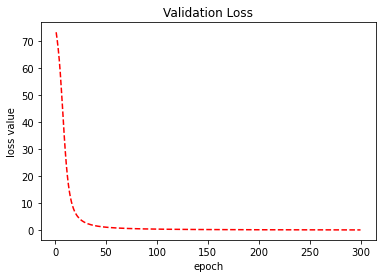

In [25]:
x = [i + 1 for i in range(len(test_loss_list))]
y = test_loss_list
l1 = plt.plot(x, y, 'r--', label='test_loss')

plt.title('Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

torch.nn实现的前馈神经网络（解决二分类问题）

In [26]:
class Feedforward(nn.Module):
  def __init__(self, feature, hidden):
    super(Feedforward, self).__init__()
    self.hidden = nn.Linear(feature, hidden)
    self.out = nn.Linear(hidden, 1)
    self.act = nn.Sigmoid()
 
  def forward(self, x):
    x = self.hidden(x)
    x = self.out(x)
    return self.act(x)

In [34]:
device = 'cuda:1'
# 模型定义
model = Feedforward(200, 5).to(device)
# 超参数与前置步骤设置
epoch_num = 100
lr = 0.01
feature_dim = 500
opt = torch.optim.SGD(model.parameters(), lr = lr)
loss = torch.nn.MSELoss(reduction='mean')
batch_size = 128

train_loss_list = []
test_loss_list = []

In [35]:
for epoch in range(epoch_num):
    for x, y in data_iter(batch_size, x_train, y_train):
        x, y = x.to(device), y.to(device)
        y_hat = model.forward(x).squeeze(1)
        y = y.squeeze(1)
        l = loss(y_hat, y).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        train_loss_list.append(l.item()*100)

    with torch.no_grad():
        total_loss = 0
        counter = 0
        for x, y in data_iter(batch_size, x_test, y_test):
            test_x, test_y = x.to(device), y.to(device)
            test_pred = model.forward(test_x)

            l = loss(test_pred, test_y).sum()
            total_loss += l
            counter += 1
        test_loss_list.append(total_loss.item()*10000)
        print('epoch: %d, total loss: %f'%(epoch + 1, total_loss*10000 / (counter+1)))

epoch: 1, total loss: 48.071507
epoch: 2, total loss: 18.004921
epoch: 3, total loss: 10.454756
epoch: 4, total loss: 7.188723
epoch: 5, total loss: 5.408597
epoch: 6, total loss: 4.305641
epoch: 7, total loss: 3.554585
epoch: 8, total loss: 3.016724
epoch: 9, total loss: 2.611938
epoch: 10, total loss: 2.296818
epoch: 11, total loss: 2.047466
epoch: 12, total loss: 1.845518
epoch: 13, total loss: 1.676064
epoch: 14, total loss: 1.533782
epoch: 15, total loss: 1.412855
epoch: 16, total loss: 1.309892
epoch: 17, total loss: 1.218528
epoch: 18, total loss: 1.139086
epoch: 19, total loss: 1.069413
epoch: 20, total loss: 1.006475
epoch: 21, total loss: 0.951513
epoch: 22, total loss: 0.900451
epoch: 23, total loss: 0.854729
epoch: 24, total loss: 0.813180
epoch: 25, total loss: 0.775504
epoch: 26, total loss: 0.740772
epoch: 27, total loss: 0.709234
epoch: 28, total loss: 0.680374
epoch: 29, total loss: 0.652517
epoch: 30, total loss: 0.627671
epoch: 31, total loss: 0.604439
epoch: 32, tot

绘制训练loss曲线

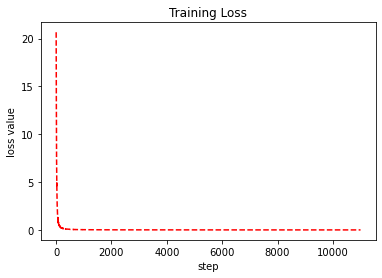

In [36]:
x = [i + 1 for i in range(len(train_loss_list))]
y = train_loss_list
l1 = plt.plot(x, y, 'r--', label='train_loss')

plt.title('Training Loss')
plt.xlabel('step')
plt.ylabel('loss value')
plt.show()

绘制验证loss曲线

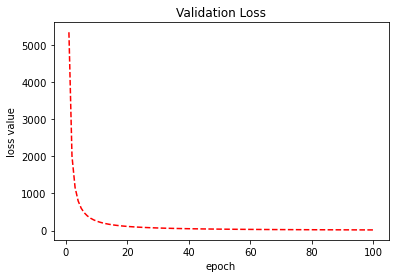

In [37]:
x = [i + 1 for i in range(len(test_loss_list))]
y = test_loss_list
l1 = plt.plot(x, y, 'r--', label='test_loss')

plt.title('Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()